In [1]:
import pandas as pd
import numpy as np
import torch.multiprocessing as mp
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, MinMaxScaler
from Categorization import Categorizer
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
import torch
import copy
from torch.nn.functional import one_hot
from torch.utils.data import DataLoader, TensorDataset, random_split
import imblearn
from collections import Counter


In [2]:
import pandas as pd
import numpy as np
import torch.multiprocessing as mp
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, MinMaxScaler
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import PolynomialFeatures
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from scipy.interpolate import interp1d
from Categorization import Categorizer
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import copy
from torch.nn.functional import one_hot
import imblearn
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint
from collections import Counter
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from dask.dataframe import from_pandas
from tsfresh.utilities.distribution import MultiprocessingDistributor
from sklearn.model_selection import StratifiedKFold, train_test_split
import hashlib 
from sklearn.metrics import precision_recall_fscore_support
from importlib import reload
from temporalHelper import TemporalHelper as TH
from concurrent.futures import ProcessPoolExecutor
import os
from torch_explain.models.explainer import Explainer
import time
from torchmetrics.functional import precision_recall
from sklearn.feature_selection import mutual_info_classif, chi2
from sklearn.linear_model import LassoCV
from torch_explain.logic.metrics import formula_consistency
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, RepeatedStratifiedKFold
from func_timeout import func_set_timeout, func_timeout, FunctionTimedOut

In [3]:
mimicDF = pd.read_csv('../LEN_Test/data/StaticData.csv')
targetDF = mimicDF[['deathperiod']]

display(mimicDF['PatientID'].value_counts())

ids = mimicDF['PatientID']

display(ids)

mimicDF = mimicDF.drop(columns=['PatientID', 'deathperiod'])

categorisationTypes = {}

186706    7
108976    5
154357    4
194933    4
130738    3
         ..
108246    1
167548    1
193531    1
120875    1
131831    1
Name: PatientID, Length: 4873, dtype: int64

0       181199
1       167020
2       169463
3       183338
4       192665
         ...  
5257    106017
5258    186511
5259    188867
5260    115153
5261    131831
Name: PatientID, Length: 5262, dtype: int64

In [4]:
mimicDF.head()

,los,gender,age,comorbidity,sofa,respiration,coagulation,liver,renal,cardiovascular,cns
0,9,1,74.19,7,7,0.0,1.0,NaN,0.0,3.0,3.0
1,2,0,75.00,4,2,NaN,0.0,0.0,1.0,NaN,1.0
2,16,0,51.92,4,2,NaN,0.0,NaN,0.0,NaN,2.0
3,12,0,51.73,-13,4,2.0,2.0,NaN,0.0,NaN,0.0
4,7,0,62.07,0,3,0.0,2.0,NaN,1.0,NaN,0.0


In [5]:
mimicDF.describe()

,los,gender,age,comorbidity,sofa,respiration,coagulation,liver,renal,cardiovascular,cns
count,5262.000000,5262.000000,5262.000000,5262.000000,5262.000000,3311.000000,5227.000000,2254.000000,5261.000000,1294.000000,5212.000000
mean,14.668757,0.382554,75.049002,9.801026,4.794185,1.987315,0.674957,0.696983,1.017297,3.238022,0.768611
std,14.101457,0.486057,50.553676,9.671438,2.694694,1.374066,0.892066,1.051290,1.263514,0.706116,1.140061
min,1.000000,0.000000,16.010000,-16.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,0.000000,55.410000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000
50%,10.000000,0.000000,68.300000,9.000000,4.000000,2.000000,0.000000,0.000000,1.000000,3.000000,0.000000
75%,18.000000,1.000000,78.525000,16.000000,6.000000,3.000000,1.000000,1.000000,2.000000,4.000000,1.000000
max,202.000000,1.000000,306.880000,47.000000,22.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000


In [6]:
rowsWithNaN = sum(mimicDF.isnull().any(axis=1))
print(f"{mimicDF.shape[0]} rows in df, {rowsWithNaN} containing NaN values")

5262 rows in df, 4778 containing NaN values


### Missing values dealt with by filling with the mode.

In [7]:
for col in mimicDF:
    mimicDF[col] = mimicDF[col].fillna(mimicDF[col].mode()[0])

In [8]:
mimicDF

,los,gender,age,comorbidity,sofa,respiration,coagulation,liver,renal,cardiovascular,cns
0,9,1,74.19,7,7,0.0,1.0,0.0,0.0,3.0,3.0
1,2,0,75.00,4,2,3.0,0.0,0.0,1.0,3.0,1.0
2,16,0,51.92,4,2,3.0,0.0,0.0,0.0,3.0,2.0
3,12,0,51.73,-13,4,2.0,2.0,0.0,0.0,3.0,0.0
4,7,0,62.07,0,3,0.0,2.0,0.0,1.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
5257,120,1,36.61,5,10,3.0,3.0,4.0,0.0,3.0,0.0
5258,13,0,53.90,12,4,3.0,0.0,0.0,0.0,3.0,1.0
5259,4,0,58.93,18,5,3.0,1.0,0.0,4.0,3.0,0.0
5260,16,0,68.98,-4,3,1.0,2.0,0.0,0.0,3.0,0.0


In [9]:
mimicDF.describe()

,los,gender,age,comorbidity,sofa,respiration,coagulation,liver,renal,cardiovascular,cns
count,5262.000000,5262.000000,5262.000000,5262.000000,5262.000000,5262.00000,5262.000000,5262.000000,5262.000000,5262.000000,5262.000000
mean,14.668757,0.382554,75.049002,9.801026,4.794185,2.36279,0.670468,0.298556,1.017104,3.058533,0.761307
std,14.101457,0.486057,50.553676,9.671438,2.694694,1.19465,0.890785,0.769595,1.263472,0.364759,1.137079
min,1.000000,0.000000,16.010000,-16.000000,2.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,0.000000,55.410000,2.000000,3.000000,2.00000,0.000000,0.000000,0.000000,3.000000,0.000000
50%,10.000000,0.000000,68.300000,9.000000,4.000000,3.00000,0.000000,0.000000,1.000000,3.000000,0.000000
75%,18.000000,1.000000,78.525000,16.000000,6.000000,3.00000,1.000000,0.000000,2.000000,3.000000,1.000000
max,202.000000,1.000000,306.880000,47.000000,22.000000,4.00000,4.000000,4.000000,4.000000,4.000000,4.000000


In [10]:
rowsWithNaN = sum(mimicDF.isnull().any(axis=1))
print(f"{mimicDF.shape[0]} rows in df, {rowsWithNaN} containing NaN values")

5262 rows in df, 0 containing NaN values


#### Replaced NaN values with average of respective columns

In [11]:
dataNeedingEncodingDF = mimicDF[['los', 'age', 'comorbidity', 'sofa']]

### Fixing high age range

In [12]:
ageWithoutOutliers = dataNeedingEncodingDF['age'][dataNeedingEncodingDF['age'] < 200]

dataNeedingEncodingDF['age'] = dataNeedingEncodingDF['age'].apply(lambda x: x if x < 200 else int(ageWithoutOutliers.sample()))

dataNeedingEncodingDF.head()

C:\Users\benma\AppData\Local\Temp/ipykernel_11372/2166811324.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataNeedingEncodingDF['age'] = dataNeedingEncodingDF['age'].apply(lambda x: x if x < 200 else int(ageWithoutOutliers.sample()))


,los,age,comorbidity,sofa
0,9,74.19,7,7
1,2,75.00,4,2
2,16,51.92,4,2
3,12,51.73,-13,4
4,7,62.07,0,3


#### Does clustering in 2d here help with classification? Moving up the values will mean jumping between categories which doesn't seem right. Unless there is something special about those few numbers in dark blue

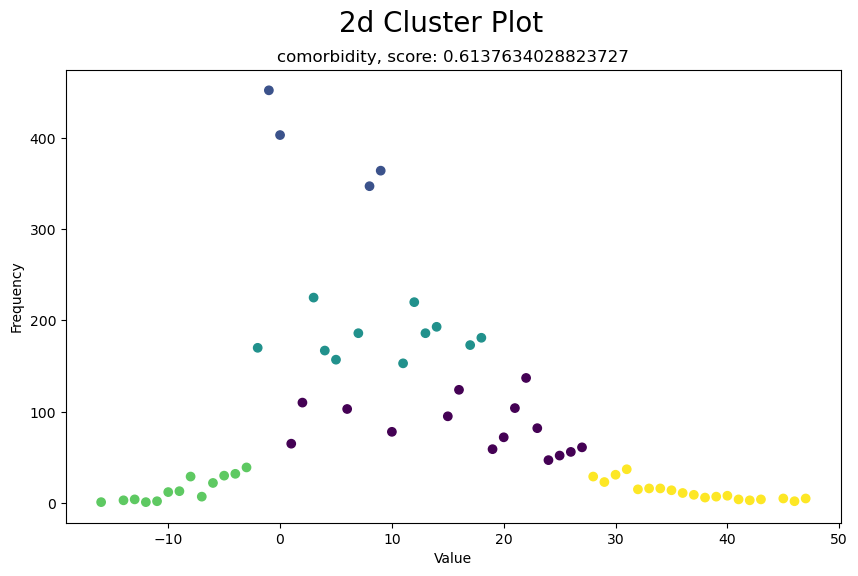

In [13]:
comorbidity = dataNeedingEncodingDF[['comorbidity']]

comorbidity = pd.DataFrame(data=list(zip(comorbidity.value_counts().index, comorbidity.value_counts().values)), columns=['comorbidity', 'count'])

comorbidity['comorbidity'] = comorbidity['comorbidity'].astype(str).apply(lambda x: x[1:-2]).astype(np.int64)

comorbidityDF = AgglomerativeClustering(n_clusters=5).fit_predict(np.asarray(comorbidity))

sil_x = np.dstack((comorbidity['comorbidity'], comorbidity['count']))[0]

score = silhouette_score(sil_x, comorbidityDF)

fig = plt.figure(figsize=(10,6), dpi=100)
fig.suptitle("2d Cluster Plot", fontsize=20)

plt.scatter(comorbidity['comorbidity'], comorbidity['count'], c=comorbidityDF)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title(f"comorbidity, score: {score}")
plt.show()

In [14]:
dataNeedingEncodingDF

,los,age,comorbidity,sofa
0,9,74.19,7,7
1,2,75.00,4,2
2,16,51.92,4,2
3,12,51.73,-13,4
4,7,62.07,0,3
...,...,...,...,...
5257,120,36.61,5,10
5258,13,53.90,12,4
5259,4,58.93,18,5
5260,16,68.98,-4,3


# Graphically representing the categorisation

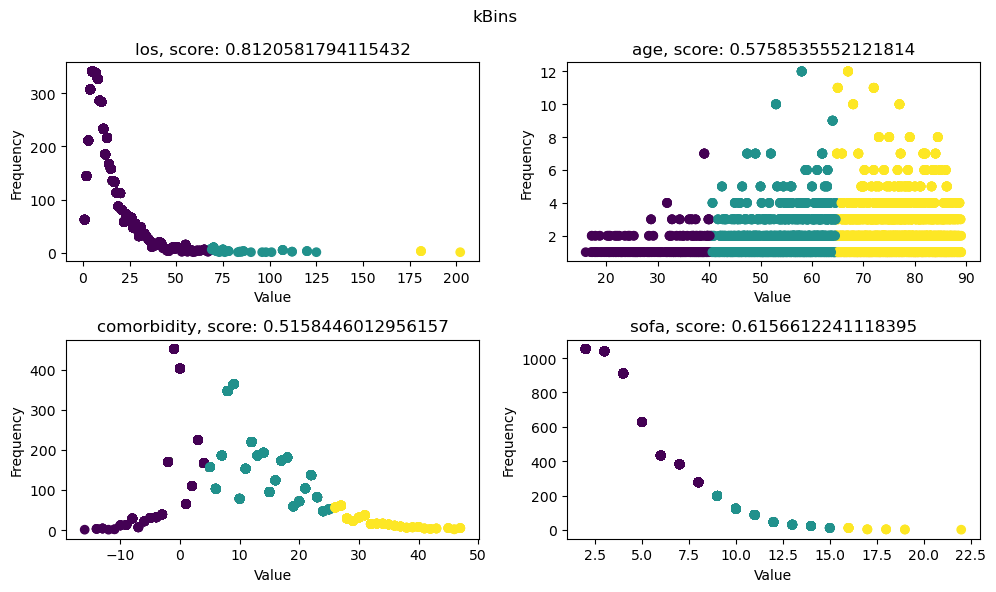

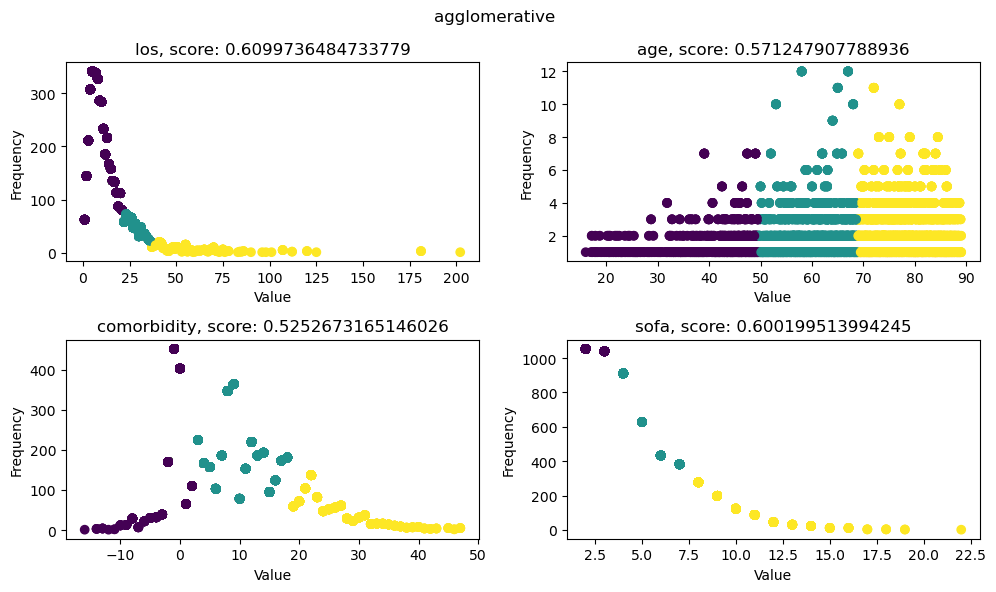

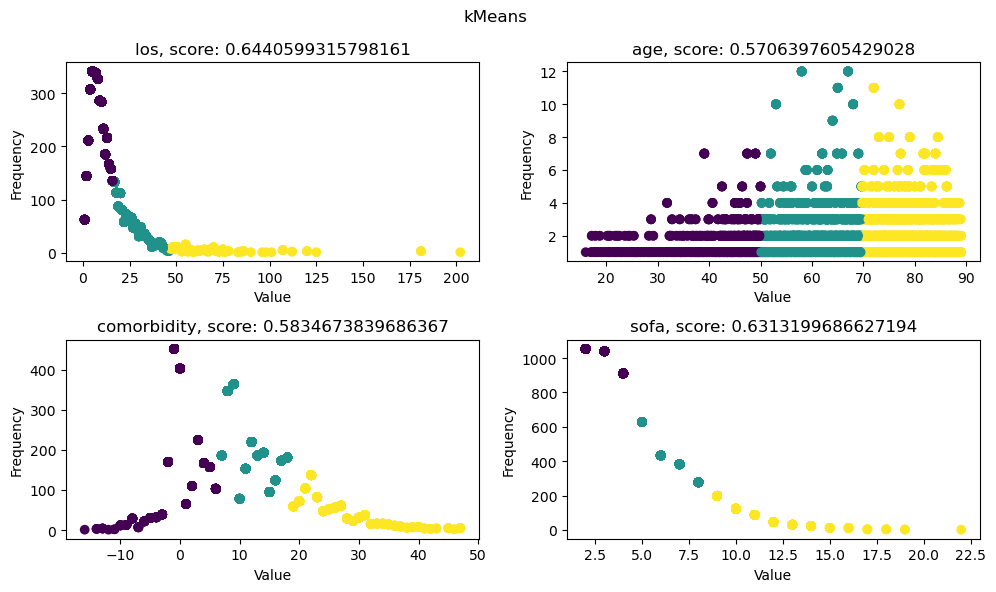

In [15]:
cat = Categorizer(dataNeedingEncodingDF)

clusters = 5

cat.kBins(bins=clusters)
cat.agglomerative(n_clusters=clusters)
cat.kMeans(n_clusters=clusters)

cat.display()

In [16]:
pd.set_option('display.max_rows', 1000)

In [17]:
# categories = {0: 'very_low', 1: 'low', 2: 'medium', 3: 'high', 4: 'very_high'}

categories = {0: 'low', 1: 'medium', 2: 'high'}


for type in cat.categorizationTypes:

    cat.categorizationTypes[type][['respiration','coagulation','liver','renal','cardiovascular','cns']] = mimicDF[['respiration','coagulation','liver','renal','cardiovascular','cns']]

    for col in cat.categorizationTypes[type].columns:
        cat.categorizationTypes[type][col] = cat.categorizationTypes[type][col].map(categories)

    cat.categorizationTypes[type]['gender'] = mimicDF['gender'].map({0:'male', 1:'female'})

    cat.categorizationTypes[type] = pd.get_dummies(cat.categorizationTypes[type])

    display(cat.categorizationTypes[type])

,los_high,los_low,los_medium,age_high,age_low,age_medium,comorbidity_high,comorbidity_low,comorbidity_medium,sofa_high,...,renal_high,renal_low,renal_medium,cardiovascular_high,cardiovascular_low,cns_high,cns_low,cns_medium,gender_female,gender_male
0,0,1,0,1,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
1,0,1,0,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,1
2,0,1,0,0,0,1,0,1,0,0,...,0,1,0,0,0,1,0,0,0,1
3,0,1,0,0,0,1,0,1,0,0,...,0,1,0,0,0,0,1,0,0,1
4,0,1,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5257,0,0,1,0,1,0,0,0,1,0,...,0,1,0,0,0,0,1,0,1,0
5258,0,1,0,0,0,1,0,0,1,0,...,0,1,0,0,0,0,0,1,0,1
5259,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
5260,0,1,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,1


,los_high,los_low,los_medium,age_high,age_low,age_medium,comorbidity_high,comorbidity_low,comorbidity_medium,sofa_high,...,renal_high,renal_low,renal_medium,cardiovascular_high,cardiovascular_low,cns_high,cns_low,cns_medium,gender_female,gender_male
0,0,1,0,1,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
1,0,1,0,1,0,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,1
2,0,1,0,0,0,1,0,0,1,0,...,0,1,0,0,0,1,0,0,0,1
3,0,1,0,0,0,1,0,1,0,0,...,0,1,0,0,0,0,1,0,0,1
4,0,1,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5257,1,0,0,0,1,0,0,0,1,1,...,0,1,0,0,0,0,1,0,1,0
5258,0,1,0,0,0,1,0,0,1,0,...,0,1,0,0,0,0,0,1,0,1
5259,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
5260,0,1,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,1


,los_high,los_low,los_medium,age_high,age_low,age_medium,comorbidity_high,comorbidity_low,comorbidity_medium,sofa_high,...,renal_high,renal_low,renal_medium,cardiovascular_high,cardiovascular_low,cns_high,cns_low,cns_medium,gender_female,gender_male
0,0,1,0,1,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
1,0,1,0,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,1
2,0,1,0,0,0,1,0,1,0,0,...,0,1,0,0,0,1,0,0,0,1
3,0,1,0,0,0,1,0,1,0,0,...,0,1,0,0,0,0,1,0,0,1
4,0,1,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5257,1,0,0,0,1,0,0,1,0,1,...,0,1,0,0,0,0,1,0,1,0
5258,0,1,0,0,0,1,0,0,1,0,...,0,1,0,0,0,0,0,1,0,1
5259,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
5260,0,1,0,0,0,1,0,1,0,0,...,0,1,0,0,0,0,1,0,0,1


### TODO Do we want to standardise the data before categorising?

If another point (eg an outlier) is added to the dataset, then this could push the other points away from their original categorisation. Need outlier detection? 

In [18]:
targetDF.describe()

,deathperiod
count,5262.000000
mean,0.896047
std,7.338713
min,-29.000000
25%,-1.000000
50%,-1.000000
75%,-1.000000
max,107.000000


In [19]:
targetDF

,deathperiod
0,-1
1,2
2,-1
3,-1
4,-1
...,...
5257,-1
5258,-1
5259,-1
5260,-1


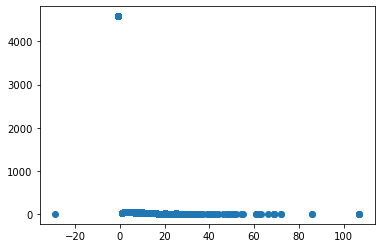

In [20]:
plt.scatter(targetDF['deathperiod'], targetDF['deathperiod'].map(targetDF['deathperiod'].value_counts()))
plt.show()

In [21]:
targetCategorisedDF = targetDF['deathperiod'].apply(lambda x: 1 if x > -1 else 0)

In [22]:
targetCategorisedDF

0       0
1       1
2       0
3       0
4       0
       ..
5257    0
5258    0
5259    0
5260    0
5261    0
Name: deathperiod, Length: 5262, dtype: int64

In [23]:
# targetDiedDF = F[targetDF['deathperiod'] > -1]
# targetNoDeathDF = targettargetDDF[targetDF['deathperiod'] == -1].apply(lambda x: x+1.0)

In [24]:
# targetDiedDF.shape

In [25]:
# targetNoDeathDF.shape

In [26]:
# bins = 3

# est = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='quantile')
# targetCategorisedDF = pd.DataFrame(data=est.fit_transform(targetDiedDF), columns=['deathperiod'])

# targetCategorisedDF['deathperiod'] = targetCategorisedDF['deathperiod'].apply(lambda x: x + 1)

# targetCategorisedDF.set_index(targetDiedDF.index, inplace=True)

# targetCategorisedDF.head()


In [27]:
# targetNoDeathDF.head()

In [28]:
# combinedTargetDF = pd.concat([targetCategorisedDF, targetNoDeathDF], axis=1)

# withDeath = combinedTargetDF.iloc[:,0]
# noDeath = combinedTargetDF.iloc[:,1]

# newTargetDF = withDeath.fillna(noDeath)

# newTargetDF = newTargetDF.astype(np.int64)

# newTargetDF.value_counts()

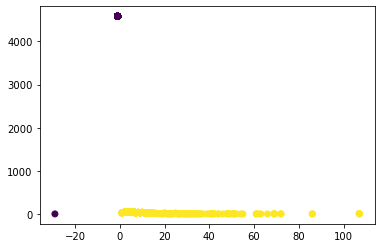

In [29]:
plt.scatter(targetDF['deathperiod'], targetDF['deathperiod'].map(targetDF['deathperiod'].value_counts()), c=targetCategorisedDF)
plt.show()

### Here without the -1 value so we can see the variance of the rest

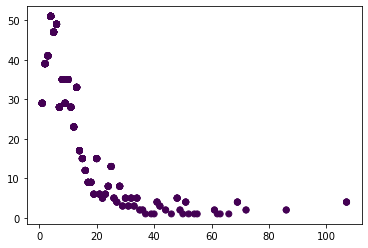

In [30]:
tempDF = targetDF[targetDF['deathperiod'] > -1]

plt.scatter(tempDF['deathperiod'], tempDF['deathperiod'].map(tempDF['deathperiod'].value_counts()), c=targetCategorisedDF[targetCategorisedDF> 0])
plt.show()

In [31]:
targetCategorisedDF.value_counts()

0    4584
1     678
Name: deathperiod, dtype: int64

In [32]:
stackedTargetDF = np.stack(targetCategorisedDF)

In [33]:
class FOL:

    def __init__(self, features):
        self.features = features

    def __repr__(self):
        out = "\n("
        for i in range(len(self.features)):
            feature = self.features[i]
            if feature.sign == 'OR':
                out += ") \nOR \n("
                continue
            out += f"{feature}"
            if i+1 < len(self.features) and self.features[i+1].sign != 'OR':
                out += " AND "
        out += ")\n"
        return out


In [34]:
class Feature:

    def __init__(self, sign=None, number=None, name=None):
        self.sign = sign
        self.name = name
        self.number = number

    def __repr__(self):
        out = ""
        if self.sign is not None:
            if self.sign == -1:
                out += "NOT_"
            # out += f"{self.sign} "
        # if self.number is not None:
        #     out += f"{self.number} "
        if self.name is not None:
            out += f"{self.name}"
        return out

In [35]:
def convertFeaturesToColumnNames(explanation, columns):
    
    features = [x for x in explanation.split(" ") if x != '&']

    featureList = []

    for feature in features:
        f = Feature()
        if feature[0] == '|':
            f.sign = 'OR'
            featureList.append(f)
            continue
        if feature[-1] == ')':
            feature = feature[:-1]
        if feature[0] == '(':
            feature = feature[1:]
        if feature[0] == '~':
            f.sign = -1
        else:
            f.sign = 1
        f.number = int(feature[-2:])
        f.name = columns[f.number]
        featureList.append(f)
    
    # print(featureList)

    fol = FOL(featureList)

    # print(fol)

    return fol
        

    # return [columns[x] for x in featureNums]

In [36]:
# list(categorisationTypes.keys())[:1]

In [37]:
mapped = cat.categorizationTypes['agglomerative']

mapped['deathperiod'] = stackedTargetDF

mapped['PatientID'] = ids

mapped

,los_high,los_low,los_medium,age_high,age_low,age_medium,comorbidity_high,comorbidity_low,comorbidity_medium,sofa_high,...,renal_medium,cardiovascular_high,cardiovascular_low,cns_high,cns_low,cns_medium,gender_female,gender_male,deathperiod,PatientID
0,0,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,181199
1,0,1,0,1,0,0,0,0,1,0,...,1,0,0,0,0,1,0,1,1,167020
2,0,1,0,0,0,1,0,0,1,0,...,0,0,0,1,0,0,0,1,0,169463
3,0,1,0,0,0,1,0,1,0,0,...,0,0,0,0,1,0,0,1,0,183338
4,0,1,0,0,0,1,0,1,0,0,...,1,0,0,0,1,0,0,1,0,192665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5257,1,0,0,0,1,0,0,0,1,1,...,0,0,0,0,1,0,1,0,0,106017
5258,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,1,0,1,0,186511
5259,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,1,0,188867
5260,0,1,0,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0,115153


In [38]:
dataname = "staticData.csv"

mapped.to_csv(f"./categorisedData/{dataname}")

In [39]:
@func_set_timeout(60)
def explain_with_timeout(model, val_data, train_data, test_data, topk_expl, concepts):

    return model.explain_class(val_dataloaders=val_data, train_dataloaders=train_data, test_dataloaders=test_data, topk_explanations=topk_expl, concept_names=concepts)

In [40]:

results_dict = {}

data = mapped

targetName = "deathperiod"

targetSeries = data[targetName]
data = data.drop(columns=[targetName])


dataTensor = torch.FloatTensor(data.to_numpy())
targetTensor = one_hot(torch.tensor(targetSeries.values).to(torch.long)).to(torch.float)


dataset = TensorDataset(dataTensor, targetTensor)
train_size = int(0.8 * len(dataset))

val_size = (len(dataset) - train_size) // 2
test_size = len(dataset) - train_size - val_size

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_data, batch_size=train_size)
val_loader = DataLoader(val_data, batch_size=val_size)
test_loader = DataLoader(test_data, batch_size=test_size)



n_concepts = next(iter(train_loader))[0].shape[1]
# self.n_concepts = n_concepts


n_classes = targetTensor.shape[1]
# self.n_classes = n_classes

print("Training on {} classes".format(n_classes))

print("Num concepts: {}".format(n_concepts))
print("Num classes: {}".format(n_classes))

base_dir = f'./results/mimicLEN/explainer'
os.makedirs(base_dir, exist_ok=True)

seed_everything(40)

n_splits = 5

# self.n_splits = n_splits

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# self.skf = skf

results_list = []
feature_selection = []
explanations = {i: [] for i in range(n_classes)}

explanations_list = []
splitResults_list = []
scores_list = []

x = dataTensor
y = targetTensor


for split, (trainval_index, test_index) in enumerate(skf.split(x.cpu().detach().numpy(),
                                                        y.argmax(dim=1).cpu().detach().numpy())):
    

    print(f'Split [{split + 1}/{n_splits}]')
    x_trainval, x_test = torch.FloatTensor(x[trainval_index]), torch.FloatTensor(x[test_index])
    y_trainval, y_test = torch.FloatTensor(y[trainval_index]), torch.FloatTensor(y[test_index])
    x_train_unbalanced, x_val, y_train_unbalanced, y_val = train_test_split(x_trainval, y_trainval, test_size=0.2, random_state=42)
    print(f'{len(y_train_unbalanced)}/{len(y_val)}/{len(y_test)}')


    # Rebalancing training set
    obj = imblearn.over_sampling.SMOTEN(random_state=0, n_jobs=4)

    print(sorted(Counter(torch.argmax(y_train_unbalanced, axis=1).numpy()).items()))

    x_train, y_train = obj.fit_resample(x_train_unbalanced.numpy(), torch.argmax(y_train_unbalanced, axis=1).numpy())

    print(sorted(Counter(y_train).items()))

    y_train = one_hot(torch.tensor(y_train).to(torch.long)).to(torch.float)
    x_train = torch.FloatTensor(x_train)

    train_data = TensorDataset(x_train, y_train)
    val_data = TensorDataset(x_val, y_val)
    test_data = TensorDataset(x_test, y_test)
    train_loader = DataLoader(train_data, batch_size=train_size)
    val_loader = DataLoader(val_data, batch_size=val_size)
    test_loader = DataLoader(test_data, batch_size=test_size)

    checkpoint_callback = ModelCheckpoint(dirpath=base_dir, monitor='val_loss', save_top_k=1)

    # Constructs the way that the model will be trained
    trainer = Trainer(max_epochs=200, gpus=1, auto_lr_find=True, deterministic=True,
                    check_val_every_n_epoch=1, default_root_dir=base_dir,
                    weights_save_path=base_dir, callbacks=[checkpoint_callback], enable_progress_bar=False)

    # This is the model itself, which is extended from pytorch_lightning
    model = Explainer(n_concepts=n_concepts, n_classes=n_classes, l1=1e-3, lr=0.01,
                    explainer_hidden=[20], temperature=0.7)


    start = time.time()
    trainer.fit(model, train_loader, val_loader)
    # print(f"Gamma: {model.model[0].concept_mask}")
    model.freeze()
    print("\nTesting...\n")
    model_results = trainer.test(model, test_dataloaders=test_loader)
    print("\nExplaining\n")
    
    try:

        results, f = explain_with_timeout(model, val_data=val_loader, train_data=train_loader, test_data=test_loader,
                                    topk_expl=10,
                                    concepts=data.columns)
    except FunctionTimedOut:
        print("Explanation timed out, skipping...")
        # explanations_list.append(None)
        # results_list.append(None)
        continue

    end = time.time()
    # explanations_list.append(f)

    print(f"Explaining time: {end - start}")
    results['model_accuracy'] = model_results[0]['test_acc']
    results['extraction_time'] = end - start

    results_list.append(results)
    extracted_concepts = []
    all_concepts = model.model[0].concept_mask[0] > 0.5
    common_concepts = model.model[0].concept_mask[0] > 0.5
    for j in range(n_classes):
        # print(f[j]['explanation'])
        n_used_concepts = sum(model.model[0].concept_mask[j] > 0.5)
        print(f"Number of features that impact on target {j}: {n_used_concepts}")
        print(f"Explanation for target {j}: {f[j]['explanation']}")
        print(f"Explanation accuracy: {f[j]['explanation_accuracy']}")
        explanations[j].append(f[j]['explanation'])
        extracted_concepts.append(n_used_concepts)
        all_concepts += model.model[0].concept_mask[j] > 0.5
        common_concepts *= model.model[0].concept_mask[j] > 0.5

    explanations_list.append(explanations)

    results['extracted_concepts'] = np.mean(extracted_concepts)
    results['common_concepts_ratio'] = sum(common_concepts) / sum(all_concepts)

    # Precision, Recall, F1
    # print(x_test)
    y_pred = torch.argmax(model(x_test), axis=1)
    # print("Predictions:", y_pred)
    y_test_argmax = torch.argmax(y_test, axis=1)
    # print("Actual:", y_test_argmax)

    scores = [f1_score(y_test_argmax.numpy(), y_pred.numpy(), average='macro'), recall_score(y_test_argmax.numpy(), y_pred.numpy(), average='macro'), precision_score(y_test_argmax.numpy(), y_pred.numpy(), average='macro')]

    print(f"{dataname} split {split+1} scores: {scores}")

    scores_list.append(scores)

    # compare against standard feature selection
    i_mutual_info = mutual_info_classif(x_trainval, y_trainval[:, 1])
    i_chi2 = chi2(x_trainval, y_trainval[:, 1])[0]
    i_chi2[np.isnan(i_chi2)] = 0
    lasso = LassoCV(cv=5, random_state=0).fit(x_trainval, y_trainval[:, 1])
    i_lasso = np.abs(lasso.coef_)
    i_mu = model.model[0].concept_mask[1]
    # print(model.model[0].concept_mask)
    df = pd.DataFrame(np.hstack([
        i_mu.numpy(),
        # i_mutual_info / np.max(i_mutual_info),
        # i_chi2 / np.max(i_chi2),
        # i_lasso / np.max(i_lasso),
    ]).T, columns=['feature importance'])
    df['method'] = 'explainer'
    # df.iloc[90:, 1] = 'MI'
    # df.iloc[180:, 1] = 'CHI2'
    # df.iloc[270:, 1] = 'Lasso'
    df['feature'] = np.hstack([np.arange(0, n_concepts)])
    feature_selection.append(df)

    splitResults = [results['model_accuracy'], results['extraction_time'], *scores, f]

    splitResults_list.append(splitResults)


results_dict[dataname] = splitResults_list

# results_dict[file] = [results['model_accuracy'], results['extraction_time'], *scores, f]
# self.feature_selection = feature_selection
# # print(self.feature_selection)

# self.df = df
# self.explanations = explanations
# self.results_list = results_list
# print(results_dict)

Global seed set to 40


Training on 2 classes
Num concepts: 32
Num classes: 2
Split [1/5]
3367/842/1053
[(0, 2928), (1, 439)]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[(0, 2928), (1, 2928)]



  | Name  | Type             | Params
-------------------------------------------
0 | loss  | CrossEntropyLoss | 0     
1 | model | Sequential       | 1.3 K 
-------------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:631: UserWarning: Checkpoint directory C:\Users\benma\OneDrive\Kings\Modules\Term 2\Individual Project\LEN Individual Project\Static\results\mimicLEN\explainer exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `Da


Testing...

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.12915480136871338, 'test_acc_epoch': 0.12915480136871338}
--------------------------------------------------------------------------------

Explaining



c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Explaining time: 34.04586410522461
Number of features that impact on target 0: 2
Explanation for target 0: None
Explanation accuracy: 0
Number of features that impact on target 1: 1
Explanation for target 1: None
Explanation accuracy: 0
staticData.csv split 1 scores: [0.11438183347350715, 0.5, 0.06457739791073125]


c:\Users\benma\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Split [2/5]
3367/842/1053
[(0, 2946), (1, 421)]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | loss  | CrossEntropyLoss | 0     
1 | model | Sequential       | 1.3 K 
-------------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:631: UserWarning: Checkpoint directory C:\Users\benma\OneDrive\Kings\Modules\Term 2\Individual Project\LEN Individual Project\Static\results\mimicLEN\explainer exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers

[(0, 2946), (1, 2946)]


c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:432: UserWarning: The number of training samples (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
